In [1]:
import bagpy
from bagpy import bagreader
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from functools import reduce
from scipy.spatial.transform import Rotation
import ipympl
%matplotlib widget
import json

import re

def str_to_list(s):
    # Split the string by comma and iterate over the resulting list
    entries = s.split(', ')
    result = []
    for entry in entries:
        # Use regular expression to extract key-value pairs
        pairs = re.findall(r'(\w+): (.*?)\n', entry)
        # Convert pairs to dictionary and append to result list
        result.append(dict(pairs))
    return result

sns.set_theme()
# LaTex must be installed for this to work
# sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended cm-super

plt.rcParams['text.usetex'] = True
plt.rc('text.latex', preamble=r'\usepackage{bm}')

sns.set_theme()
# LaTex must be installed for this to work
# sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended cm-super

plt.rcParams['text.usetex'] = True
plt.rc('text.latex', preamble=r'\usepackage{bm}')

def drop_columns_in_df(df):
    return df.drop(columns=["header.seq", "header.stamp.secs", "header.stamp.nsecs", "header.frame_id"])

def rename_columns(df, new_colum_names: list):
    column_names = ['Time'] + new_colum_names
    
    df.columns= column_names

    return df

def normalize_df_time(df):
    start_time = df['Time'].iloc[0]

    df['Time'] -= start_time

    return df

def sync_dfs_based_on_time(dataframes: list):
    df_merged = reduce(lambda left,right: pd.merge_asof(left, right, on="Time", allow_exact_matches=True, direction="nearest", tolerance=0.01), dataframes)

    return df_merged

def df_from_pose_to_euler(df):
    quat_df = df[['pose.orientation.x', 'pose.orientation.y', 'pose.orientation.z', 'pose.orientation.w']]
    rot = Rotation.from_quat(quat_df)
    rot_euler = rot.as_euler('xyz', degrees=True)
    euler_df = pd.DataFrame(data=rot_euler, columns=['roll', 'pitch', 'yaw'])

    conc = [df, euler_df]

    df_gt_euler = pd.concat(
        conc,
        axis=1,
        join="outer",
        ignore_index=False,
        keys=None,
        levels=None,
        names=None,
        verify_integrity=False,
        copy=True,
    )

    df_gt_euler = drop_columns_in_df(df_gt_euler)
    df_gt_euler.drop(columns=["pose.position.x", "pose.position.y", "pose.position.z", "pose.orientation.x", "pose.orientation.y","pose.orientation.z","pose.orientation.w"], inplace=True)

    return df_gt_euler

def Mask_Or_Drop_Successive_Identical_Values(df, drop=False, 
                                             keep_first=True,
                                             axis=0):

    '''
    Input:
    df should be a pandas.DataFrame of a a pandas.Series
    Output:
    df of ts with masked or dropped values
    '''
    
    # Mask keeping the first occurrence
    if keep_first:
        df = df.mask(df.shift(1) == df)
    # Mask including the first occurrence
    else:
        df = df.mask((df.shift(1) == df) | (df.shift(-1) == df))

    # Drop the values (e.g. rows are deleted)    
    if drop:
        return df.dropna(axis=axis)        
    # Only mask the values (e.g. become 'NaN')
    else:
        return df

def get_np_arr_without_nan(df, datacols_list, remove_identicals=True):
    if remove_identicals:
      df_with_NAN = Mask_Or_Drop_Successive_Identical_Values(df)
    else:
      df_with_NAN = df

    column_names = ['Time'] + datacols_list

    selected_rows = df_with_NAN[~df_with_NAN[datacols_list[0]].isnull()]
    reduced_df_without_NAN = selected_rows[column_names]

    return reduced_df_without_NAN.to_numpy()

# Read bag with data

In [2]:
b = bagreader('/home/msccomputer/Desktop/2023-03-21-08-19-19.bag')
b.topic_table

[INFO]  Successfully created the data folder /home/msccomputer/Desktop/2023-03-21-08-19-19.


,Topics,Types,Message Count,Frequency
0,/anafi/images,sensor_msgs/Image,807,30.023543
1,/rosout,rosgraph_msgs/Log,6,260.904703
2,/rosout_agg,rosgraph_msgs/Log,3,271.379380
3,/search/image_tracks,sensor_msgs/Image,825,30.020427
4,/search/tracks,yolov8_ros/BoundingBoxes,274,29.892696
5,/track_GT,yolov8_ros/BoundingBoxes,274,30.134092
6,/yolo/search/boxes,yolov8_ros/BoundingBoxes,807,30.041176


In [3]:
def ret_track_df(df):
    # create an empty list to store DataFrames
    dfs = []

    # iterate over rows of the original DataFrame
    for index, row in df.iterrows():
        # split the bounding boxes string into individual boxes
        bbs = row['bbs'].replace('[','').replace(']','').split(', ')
        # create a DataFrame for each box and append it to the list of DataFrames
        for bb in bbs:
            bb_dict = {}
            for item in bb.split("\n"):
                key, value = item.split(": ")
                bb_dict[key.strip()] = float(value) if key.strip() not in ["id", "Class"] else value.strip().replace('"', '')
            new_row = {**row.to_dict(), **bb_dict}
            dfs.append(pd.DataFrame(new_row, index=[index]))

    # concatenate the list of DataFrames into a single DataFrame
    new_df = pd.concat(dfs, axis=0, ignore_index=True)

    new_df = new_df[["Time", "probability",	"xmin",	"ymin",	"xmax",	"ymax",	"id",	"Class"]]

    new_df['id'] = new_df['id'].astype(int)

    # extract the desired columns using loc
    new_df = new_df.loc[:, ['Time', 'id', 'probability', 'Class', 'xmin', 'ymin', 'xmax', 'ymax']]

    # calculate the center x and y coordinates
    new_df['center_x'] = (new_df['xmin'] + new_df['xmax']) / 2
    new_df['center_y'] = (new_df['ymin'] + new_df['ymax']) / 2

    # drop the original xmin, ymin, xmax, ymax columns
    new_df.drop(columns=['xmin', 'ymin', 'xmax', 'ymax'], inplace=True)

    return new_df



## Extract GT tracks

In [4]:
GT_tracks = b.message_by_topic('/track_GT')
df_GT_tracks = pd.read_csv(GT_tracks)

df_GT_tracks = rename_columns(df_GT_tracks[["Time", "bounding_boxes"]], ["bbs"])

df_GT_tracks = ret_track_df(df_GT_tracks)

df_GT_tracks



,Time,id,probability,Class,center_x,center_y
0,1.679383e+09,-1,0.8,human,776.5,709.5
1,1.679383e+09,-1,0.8,human,776.0,708.5
2,1.679383e+09,-1,0.8,human,776.0,707.0
3,1.679383e+09,-1,0.8,human,775.5,706.0
4,1.679383e+09,-1,0.8,human,775.0,704.5
...,...,...,...,...,...,...
487,1.679383e+09,-2,0.8,human,630.5,29.0
488,1.679383e+09,-2,0.8,human,630.5,26.0
489,1.679383e+09,-2,0.8,human,630.5,23.0
490,1.679383e+09,-2,0.8,human,630.5,21.0


## Extract est tracks 

In [5]:
est_tracks = b.message_by_topic('/search/tracks')
df_est_tracks = pd.read_csv(est_tracks)

df_est_tracks = rename_columns(df_est_tracks[["Time", "bounding_boxes"]], ["bbs"])

df_est_tracks = ret_track_df(df_est_tracks)

df_est_tracks


,Time,id,probability,Class,center_x,center_y
0,1.679383e+09,1,0.8,human,781.5,646.5
1,1.679383e+09,1,0.8,human,782.5,643.0
2,1.679383e+09,1,0.8,human,782.5,641.0
3,1.679383e+09,1,0.8,human,782.5,639.0
4,1.679383e+09,1,0.8,human,782.5,637.0
...,...,...,...,...,...,...
485,1.679383e+09,5,0.8,human,635.0,-48.5
486,1.679383e+09,5,0.8,human,635.0,-51.5
487,1.679383e+09,5,0.8,human,635.0,-54.0
488,1.679383e+09,5,0.8,human,635.5,-57.0


In [6]:
con = pd.concat([df_GT_tracks,df_est_tracks]).reset_index(drop=True)

con = normalize_df_time(con)

# X AGAINST Y

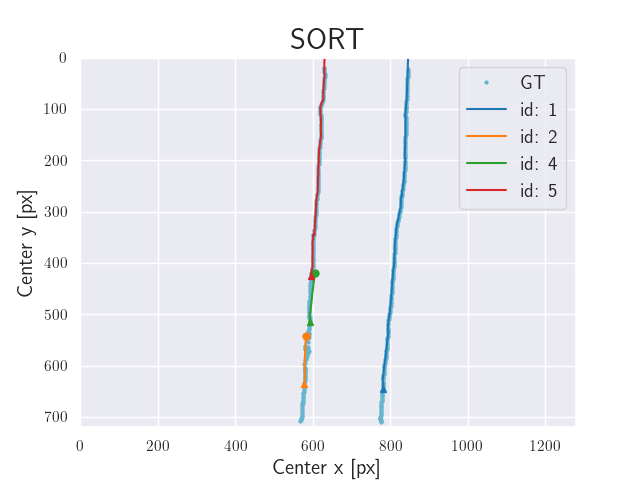

In [7]:
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

name = "tab10"
cmap = get_cmap(name)  # type: matplotlib.colors.ListedColormap
colors = cmap.colors  # type: list

fig, ax = plt.subplots()

i = 0
plot_legend = True
# loop through unique id values and plot the corresponding trajectories
for id_value in con['id'].unique():
    # extract the rows with the specific id value
    df_filtered = con[con['id'] == id_value]
    # plot the trajectory with a different color
    if not id_value == -996:
        if id_value < 0 or id_value == 0:
            if plot_legend:
                ax.plot(df_filtered['center_x'], df_filtered['center_y'], 'o', ms=2, label=f"GT", c = 'c')
                plot_legend = False
            else:
                ax.plot(df_filtered['center_x'], df_filtered['center_y'], 'o', ms=2, c = 'c')
        else:
            ax.plot(df_filtered['center_x'], df_filtered['center_y'], ms=1, label=f"id: {id_value}", c = colors[i])
            ax.plot(df_filtered['center_x'].iloc[0], df_filtered['center_y'].iloc[0], '^', ms=5, c = colors[i])
            ax.plot(df_filtered['center_x'].iloc[-1], df_filtered['center_y'].iloc[-1], 'o', ms=5, c = colors[i])

            i += 1

ax.set_title("SORT", fontsize=22, weight='bold')
ax.set_xlabel("Center x [px]", fontsize=15, weight='bold')
ax.set_ylabel("Center y [px]", fontsize=15, weight='bold')
ax.set_ylim([0,720])
ax.set_xlim([0,1280])
ax.grid(True)
ax.legend(fontsize=14)
ax.invert_yaxis()

if input("Save fig?") == "y":
    plt.savefig("SORT_x_vs_y_DJI_0064.svg")

# ONLY Y

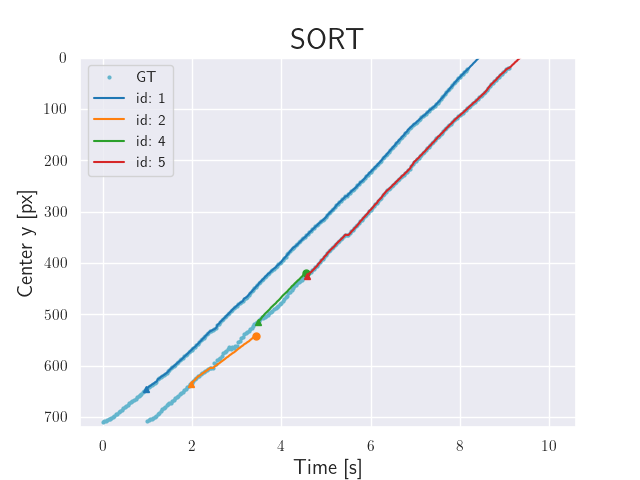

In [8]:
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

name = "tab10"
cmap = get_cmap(name)  # type: matplotlib.colors.ListedColormap
colors = cmap.colors  # type: list

fig, ax = plt.subplots()

i = 0
plot_legend = True
# loop through unique id values and plot the corresponding trajectories
for id_value in con['id'].unique():
    # extract the rows with the specific id value
    df_filtered = con[con['id'] == id_value]
    # plot the trajectory with a different color
    if not id_value == -969:
        if id_value < 0 or id_value == 0:
            if plot_legend:
                ax.plot(df_filtered['Time'], df_filtered['center_y'], 'o', ms=2, label=f"GT", c = 'c')
                plot_legend = False
            else:
                ax.plot(df_filtered['Time'], df_filtered['center_y'], 'o', ms=2, c = 'c')
        else:
            ax.plot(df_filtered['Time'], df_filtered['center_y'], ms=1, label=f"id: {id_value}", c = colors[i])
            ax.plot(df_filtered['Time'].iloc[0], df_filtered['center_y'].iloc[0], '^', ms=5, c = colors[i])
            ax.plot(df_filtered['Time'].iloc[-1], df_filtered['center_y'].iloc[-1], 'o', ms=5, c = colors[i])

            i += 1

ax.set_title("SORT", fontsize=22, weight='bold')
ax.set_xlabel("Time [s]", fontsize=15, weight='bold')
ax.set_ylabel("Center y [px]", fontsize=15, weight='bold')
ax.set_ylim([0,720])
ax.grid(True)
ax.legend()
ax.invert_yaxis()

if input("Save fig?") == "y":
    plt.savefig("SORT_time_vs_y_2hz.svg")

# X AND Y vs TIME

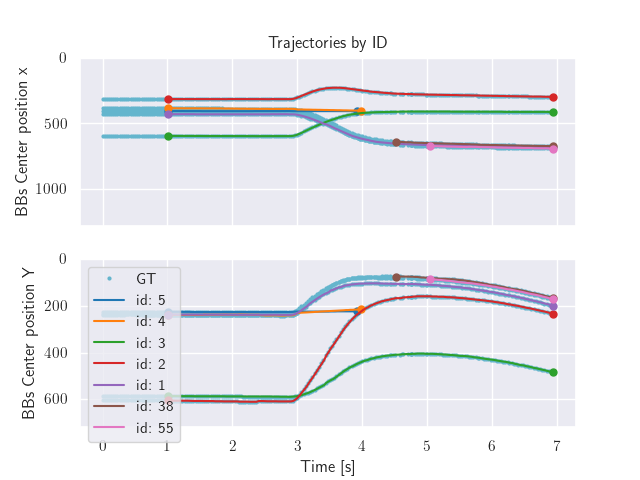

In [180]:
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

name = "tab10"
cmap = get_cmap(name)  # type: matplotlib.colors.ListedColormap
colors = cmap.colors  # type: list

fig, ax = plt.subplots(2,1)

i = 0
plot_legend = True
# loop through unique id values and plot the corresponding trajectories
for id_value in con['id'].unique():
    # extract the rows with the specific id value
    df_filtered = con[con['id'] == id_value]
    # plot the trajectory with a different color
    if not id_value == -999:
        if id_value < 0 or id_value == 0:
            if plot_legend:
                ax[0].plot(df_filtered['Time'], df_filtered['center_x'], 'o', ms=2, label=f"GT", c = 'c')
                plot_legend = False
            else:
                ax[0].plot(df_filtered['Time'], df_filtered['center_x'], 'o', ms=2, c = 'c')
        else:
            ax[0].plot(df_filtered['Time'], df_filtered['center_x'], ms=1, label=f"id: {id_value}", c = colors[i])
            ax[0].plot(df_filtered['Time'].iloc[0], df_filtered['center_x'].iloc[0], 'o', ms=5, c = colors[i])
            ax[0].plot(df_filtered['Time'].iloc[-1], df_filtered['center_x'].iloc[-1], 'o', ms=5, c = colors[i])

            i += 1

ax[0].set_title("Trajectories by ID")
ax[0].set_ylabel("BBs Center position x")
ax[0].set_ylim([0,1280])
ax[0].grid(True)
ax[0].set_xticklabels([])
ax[0].invert_yaxis()


i = 0
plot_legend = True
# loop through unique id values and plot the corresponding trajectories
for id_value in con['id'].unique():
    # extract the rows with the specific id value
    df_filtered = con[con['id'] == id_value]
    # plot the trajectory with a different color
    if not id_value == -999:
        if id_value < 0 or id_value == 0:
            if plot_legend:
                ax[1].plot(df_filtered['Time'], df_filtered['center_y'], 'o', ms=2, label=f"GT", c = 'c')
                plot_legend = False
            else:
                ax[1].plot(df_filtered['Time'], df_filtered['center_y'], 'o', ms=2, c = 'c')
        else:
            ax[1].plot(df_filtered['Time'], df_filtered['center_y'], ms=1, label=f"id: {id_value}", c = colors[i])
            ax[1].plot(df_filtered['Time'].iloc[0], df_filtered['center_y'].iloc[0], 'o', ms=5, c = colors[i])
            ax[1].plot(df_filtered['Time'].iloc[-1], df_filtered['center_y'].iloc[-1], 'o', ms=5, c = colors[i])

            i += 1
    
    
# set plot title and labels
ax[1].set_xlabel("Time [s]")
ax[1].set_ylabel("BBs Center position Y")
ax[1].set_ylim([0,720])
ax[1].legend(loc='best')
ax[1].invert_yaxis()

plt.show()


# RUNTIMES

### DeepSORT

In [118]:
arr = np.load("/home/msccomputer/catkin_ws/src/msc_thesis/deepsort_tracker/data/runtime.npy")

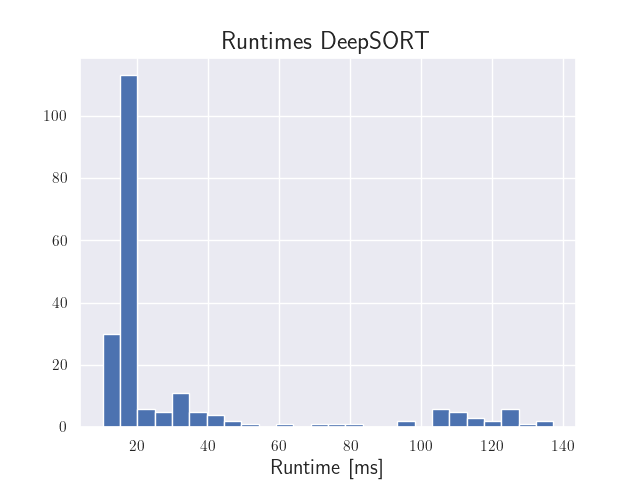

In [121]:
plt.figure()

plt.hist(arr, bins="auto")
 
plt.title("Runtimes DeepSORT", fontsize=18, weight='bold')
 
plt.xlabel("Runtime [ms]", fontsize=15, weight='bold')
# show plot
plt.show()

if input("Save fig?") == "y":
    plt.savefig("DeepSORT_runtimes.svg")

### SORT

In [122]:
arr = np.load("/home/msccomputer/catkin_ws/src/msc_thesis/sort_tracker/data/runtime.npy")

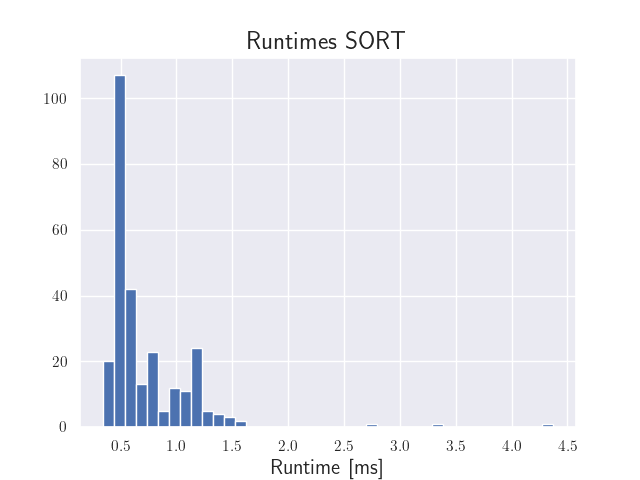

In [126]:
plt.figure()

plt.hist(arr, bins="auto")
 
plt.title("Runtimes SORT", fontsize=18, weight='bold')
 
plt.xlabel("Runtime [ms]", fontsize=15, weight='bold')
# show plot
# plt.xlim([0, 150])
plt.show()


if input("Save fig?") == "y":
    plt.savefig("SORT_runtimes.svg")